In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 20,
    "validation_file" : 5,
    "test_file" : 1,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM14",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))
# fix test set
test_files = ["./data/^GSPC.csv","./data/AAPL.csv","./data/MSFT.csv","./data/AMZN.csv","./data/NVDA.csv","./data/GOOGL.csv","./data/TSLA.csv","./data/META.csv"]

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/154789 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30888 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/69166 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


In [5]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,1,batch_first=True,bias=True)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 64
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(4,self.hidden_size)
        self.layer2 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer3 = nn.Linear(self.hidden_size,1,bias=True)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        h2 = self.layer2(h1)
        output = self.layer3(h2[:,-1,:])
        output = torch.multiply(output,0.04)
        return output

In [6]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         17,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    128
├─LSTMBlock: 1-2                         --
|    └─LSTM: 2-4                         33,280
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    128
├─Linear: 1-3                            65
Total params: 51,521
Trainable params: 51,521
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         17,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    128
├─LSTMBlock: 1-2                         --
|    └─LSTM: 2-4                         33,280
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    128
├─Linear: 1-3                            65
Total params: 51,521
Trainable params: 51,521
Non-trainable params: 0

In [7]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],4)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [8]:
loss_fn = torch.nn.L1Loss()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [11]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014860705972173772
val loss :  0.012171612150600383


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014851683697125865
val loss :  0.01216904003356482


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014848578127679844
val loss :  0.012183388667132878


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014846937324934929
val loss :  0.012157525312290599


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014841880353777238
val loss :  0.012173145685653766


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014837982222562626
val loss :  0.012155164188555794


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.01483264790086589
val loss :  0.012150183908757151


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014824871697299628
val loss :  0.01215453409044545


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014819492757511404
val loss :  0.01214682469675269


  0%|          | 0/4838 [00:00<?, ?it/s]

  0%|          | 0/966 [00:00<?, ?it/s]

train loss :  0.014815077407053366
val loss :  0.012184338924026242


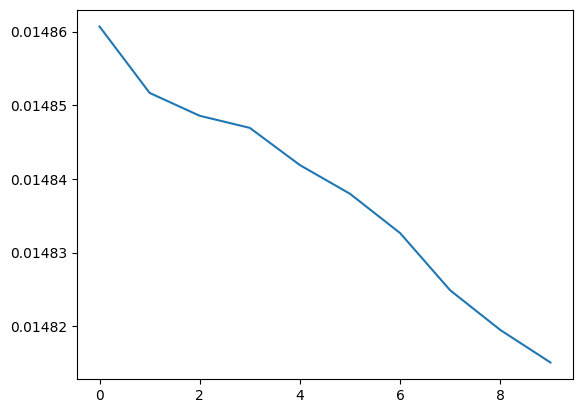

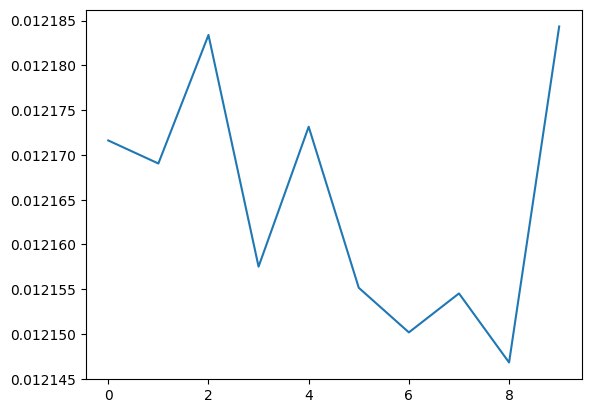

In [21]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [13]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [14]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(4, 64, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): LSTMBlock(
    (LSTM): LSTM(64, 64, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/2162 [00:00<?, ?it/s]

0.015830263909821306


In [16]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [17]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [18]:
def print_trade(best_model, stocks, output_frame) :
    for stock in tqdm(stocks) :
        predict,target = get_log_stock_prediction(best_model, [stock])
        buy_and_hold_profit = trade_test(np.ones(target.shape),target)
        naive_forecast_profit = trade_test(np.concatenate((np.array([0]),(target > 0)))[:-1],target)
        random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
        total_profit = trade_test(predict,target)
        inverse_total_profit = trade_test(-predict,target)
        
        new_row = {
            "Name": stock,
            "Buy_and_Hold" : buy_and_hold_profit,
            "Naive_Forecast" : naive_forecast_profit,
            "Random_Profit" : random_profit,
            "Total_Profit" : total_profit,
            "Inverse_Total_Profit" : inverse_total_profit
        }
        
        output_frame.loc[len(output_frame.index)] = new_row

In [19]:
testTickers = list(map(str.strip,open("testTickers.txt","r").readlines()))
test_filenames = ["./data/" + x + ".csv" for x in testTickers]
output_frame = pd.DataFrame(columns=["Name","Buy_and_Hold","Naive_Forecast","Random_Profit","Total_Profit","Inverse_Total_Profit"])
print_trade(best_model,test_filenames,output_frame)
output_frame.to_csv("./out/" + configs["model_name"] + "out.csv",index = False)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/24177 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10915 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9589 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6763 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6338 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4937 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3462 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2985 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4658 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13069 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11116 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4222 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6740 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10650 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9508 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10942 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8600 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4887 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7318 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6420 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7139 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7627 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5730 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3362 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4622 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7654 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1732 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5984 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3304 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3505 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7595 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8058 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7856 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5475 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9751 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5647 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10932 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3011 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8133 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7787 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7658 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8069 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3350 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4135 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6135 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6612 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12839 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4036 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8233 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7139 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4714 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13009 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5706 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8217 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

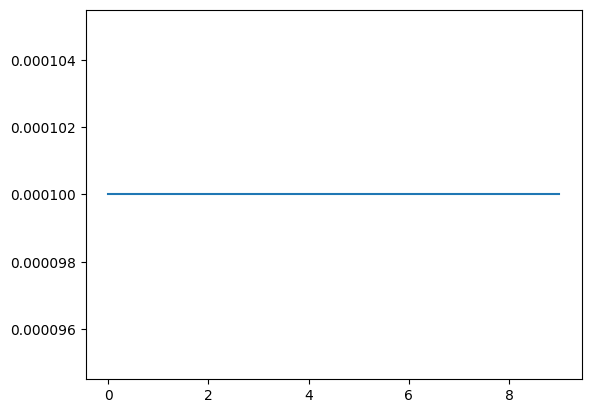

In [20]:
plt.plot(learning_rates)
plt.show()